<a href="https://colab.research.google.com/github/SyahmiSyazwan/Credit-Card-Fraud-Detection/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing required libraries




In [ ]:
# 1. Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils import shuffle

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# 2.Prep Dataset

In [ ]:
# 2. Load dataset
df = pd.read_csv('drive/MyDrive/archive/fraudTrain.csv')  # Replace with correct dataset path

# 3. Preprocessing
df.drop(columns=['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',
                 'trans_num', 'dob', 'unix_time', 'merchant', 'job', 'city', 'state'], inplace=True)

# One-hot encoding
categorical_cols = ['category', 'gender']
df = pd.get_dummies(df, columns=categorical_cols)

# Separate features and label
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Display basic information about the datasets
print("Train Data Info:")
print(df.info())

print("\nTrain Data Sample:")
print(df.head())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 25 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Unnamed: 0               1296675 non-null  int64  
 1   amt                      1296675 non-null  float64
 2   zip                      1296675 non-null  int64  
 3   lat                      1296675 non-null  float64
 4   long                     1296675 non-null  float64
 5   city_pop                 1296675 non-null  int64  
 6   merch_lat                1296675 non-null  float64
 7   merch_long               1296675 non-null  float64
 8   is_fraud                 1296675 non-null  int64  
 9   category_entertainment   1296675 non-null  bool   
 10  category_food_dining     1296675 non-null  bool   
 11  category_gas_transport   1296675 non-null  bool   
 12  category_grocery_net     1296675 non-null  bool   
 13  category_grocery_pos     

# 3. Train Model

In [ ]:
# 4. Handle Imbalanced Data using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# 5. Build MLP Model
model = Sequential()
model.add(Input(shape=(X_train_res.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
weights = {0: class_weights[0], 1: class_weights[1] * 1.5}  # boost fraud class weight
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(
    X_train_res, y_train_res,
    epochs=10,
    batch_size=2048,
    validation_split=0.2,
    class_weight=weights,
    callbacks=[early_stop]
)

# Save the model
model.save('fraud_detection_model.keras')

Epoch 1/10
806/806 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8712 - loss: 0.3808 - val_accuracy: 0.9081 - val_loss: 0.1400
Epoch 2/10
806/806 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9520 - loss: 0.1369 - val_accuracy: 0.9473 - val_loss: 0.1047
Epoch 3/10
806/806 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9602 - loss: 0.1123 - val_accuracy: 0.9589 - val_loss: 0.0951
Epoch 4/10
806/806 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9637 - loss: 0.1013 - val_accuracy: 0.9755 - val_loss: 0.0728
Epoch 5/10
806/806 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9651 - loss: 0.0963 - val_accuracy: 0.9648 - val_loss: 0.0801
Epoch 6/10
806/806 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9661 - loss: 0.0933 - val_accuracy: 0.9722 - val_loss: 0.0726
Epoch 7/10
806/806 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9673 - loss: 0.0906 - val_accuracy: 0.9709 - val_loss: 0.0737
Epoch 8/10
806/806 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9682 - loss: 0.0888 - val_accuracy: 

8105/8105 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


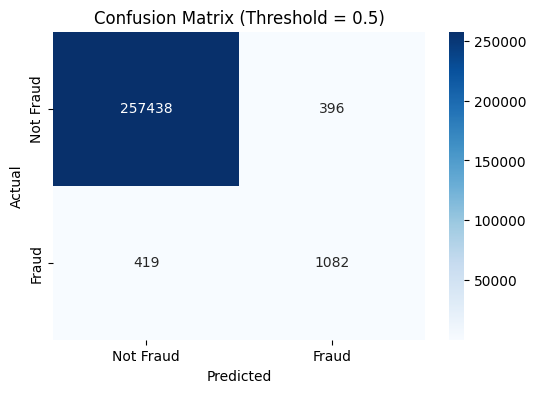


Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9985    0.9984    257834
           1     0.7321    0.7209    0.7264      1501

    accuracy                         0.9969    259335
   macro avg     0.8652    0.8597    0.8624    259335
weighted avg     0.9968    0.9969    0.9968    259335


🔍 Precision ≈ Recall at Threshold = 0.9910
Precision: 0.7249, Recall: 0.7249


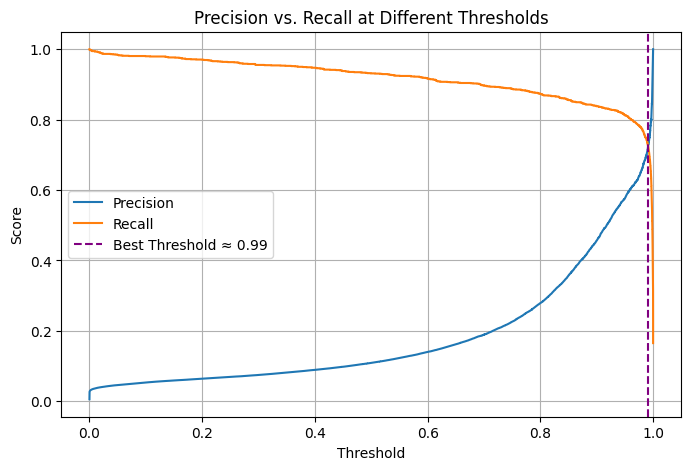

In [ ]:
# 6. Evaluation
y_probs = model.predict(X_test)
y_pred = (y_probs > 0.9918).astype("int32")#Can change threshold value from 0.5 to 0.9918 for better precision of fraud case

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Threshold = 0.5)')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Find threshold where precision ≈ recall
diff = np.abs(precisions[:-1] - recalls[:-1])
min_index = np.argmin(diff)
best_threshold = thresholds[min_index]

print(f"\n🔍 Precision ≈ Recall at Threshold = {best_threshold:.4f}")
print(f"Precision: {precisions[min_index]:.4f}, Recall: {recalls[min_index]:.4f}")

# Plot precision vs recall and best threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.axvline(x=best_threshold, color='purple', linestyle='--', label=f'Best Threshold ≈ {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs. Recall at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()


# Testing Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Explanation for Transaction 1:


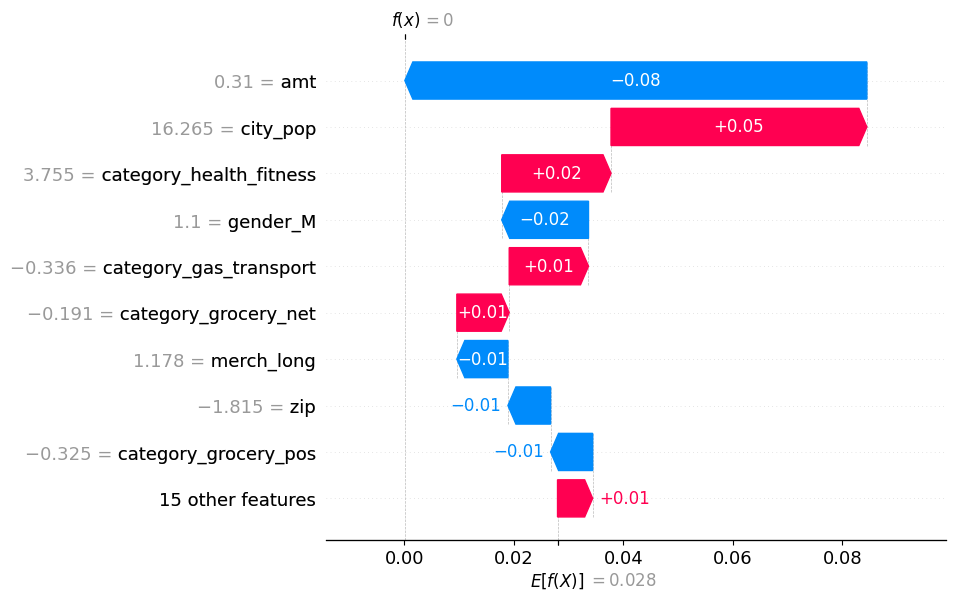


New Transaction Prediction: [('Not Fraud', np.float32(0.00010084297))]


In [ ]:
# 7. Predict New Transaction

def predict_fraud(new_data_df):
    new_data_df = pd.get_dummies(new_data_df)
    new_data_df = new_data_df.reindex(columns=X.columns, fill_value=0)
    new_scaled = pd.DataFrame(scaler.transform(new_data_df), columns=X.columns)
    prediction_probs = model.predict(new_scaled)
    classes = ['Fraud' if p > 0.5 else 'Not Fraud' for p in prediction_probs]

    # SHAP explanation
    explainer = shap.Explainer(model, pd.DataFrame(X_scaled).iloc[:100])  # Use sample from training for background
    shap_values = explainer(new_scaled)
    new_scaled.index = [f"Transaction {i+1}" for i in range(len(new_scaled))]

    for i in range(len(shap_values)):
        print(f"Explanation for Transaction {i+1}:")
        shap.plots.waterfall(shap_values[i], max_display=10)

    return list(zip(classes, prediction_probs.flatten()))

#Predict on new sample data, Lat & Long use American area
new_data = pd.DataFrame([{
    'amt': 120.0,
    'lat': 40.7128,
    'long': -74.0060,
    'city_pop': 5000000,
    'merch_lat': 40.7127,
    'merch_long': -74.0059,
    'category': 'health_fitness',
    'gender': 'M'
}])

result = predict_fraud(new_data)
print("\nNew Transaction Prediction:", result)


In [ ]:
# 8. Evaluate on fraudTest.csv and visualize
print("Evaluating on fraudTest.csv...")
test_df = pd.read_csv('drive/MyDrive/archive/fraudTest.csv')
test_df.drop(columns=['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',
                      'trans_num', 'dob', 'unix_time', 'merchant', 'job', 'city', 'state'], inplace=True)

# Extract labels
y_new = test_df['is_fraud']
X_new = test_df.drop('is_fraud', axis=1)

# One-hot encode and align columns
X_new = pd.get_dummies(X_new, columns=categorical_cols)
X_new = X_new.reindex(columns=X.columns, fill_value=0)

# Scale and predict
X_new_scaled = scaler.transform(X_new)
y_new_probs = model.predict(X_new_scaled)
y_new_pred = (y_new_probs > 0.5).astype("int32") #Can change threshold value from 0.5 to 0.9918 for better precision of fraud case



Evaluating on fraudTest.csv...
17367/17367 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


In [ ]:
# Classification Report

# Generate classification report as a dict
report_dict = classification_report(y_new, y_new_pred, digits=4, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Round values for better display
report_df = report_df.round(4)

# Display the report as a table
print("\n📊 Classification Report Table (fraudTest):")
display(report_df)


📊 Classification Report Table (fraudTest):


,precision,recall,f1-score,support
0,0.9998,0.9490,0.9737,553574.000
1,0.0667,0.9394,0.1245,2145.000
accuracy,0.9490,0.9490,0.9490,0.949
macro avg,0.5332,0.9442,0.5491,555719.000
weighted avg,0.9962,0.9490,0.9705,555719.000


Confusion Matrix (fraudTest):
[[525367  28207]
 [   130   2015]]


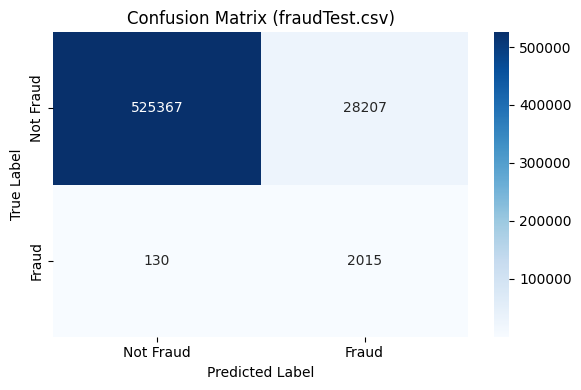

In [ ]:
# Confusion Matrix
print("Confusion Matrix (fraudTest):")
cm = confusion_matrix(y_new, y_new_pred)
print(cm)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (fraudTest.csv)')
plt.tight_layout()
plt.show()

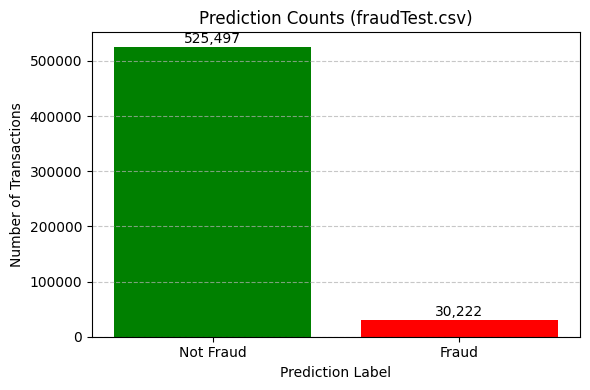

In [ ]:
# Plot bar graph of prediction counts
unique, counts = np.unique(y_new_pred, return_counts=True)
pred_counts = dict(zip(unique, counts))
labels = ['Not Fraud', 'Fraud']
values = [pred_counts.get(0, 0), pred_counts.get(1, 0)]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=['green', 'red'])

# Add data labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2000, f'{height:,}',
             ha='center', va='bottom', fontsize=10)

plt.title('Prediction Counts (fraudTest.csv)')
plt.xlabel('Prediction Label')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Plot accuracy, precision, recall, and F1 score
# Calculate metrics
accuracy = accuracy_score(y_new, y_new_pred)
precision = precision_score(y_new, y_new_pred, zero_division=0)
recall = recall_score(y_new, y_new_pred, zero_division=0)
f1 = f1_score(y_new, y_new_pred, zero_division=0)

# Create a DataFrame for metrics
metrics_dict = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
}
metrics_df = pd.DataFrame(metrics_dict).T
metrics_df.columns = ['Score']
metrics_df['Score'] = metrics_df['Score'].apply(lambda x: f"{x:.4f}")

# Display the table
display(metrics_df)

# For detailed per-class report
print(classification_report(y_new, y_new_pred, digits=4))

,Score
Accuracy,0.9490
Precision,0.0667
Recall,0.9394
F1 Score,0.1245


              precision    recall  f1-score   support

           0     0.9998    0.9490    0.9737    553574
           1     0.0667    0.9394    0.1245      2145

    accuracy                         0.9490    555719
   macro avg     0.5332    0.9442    0.5491    555719
weighted avg     0.9962    0.9490    0.9705    555719

